In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt

import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to C:\Users\Dell
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Web Scraping from [Skytrax](https://www.airlinequality.com/airline-reviews/british-airways/page/1/)

In [69]:
def get_sibling(arr, tag, class_name):
    try:
        tag_label = arr.find(tag, class_=class_name)
        value = tag_label.find_next_sibling(tag).text.strip()
        return value
    except AttributeError:
        return "null"

In [70]:
def get_stars(arr, tag, class_name, tag2, class_name2):
    try:
        tag_label = arr.find(tag, class_=class_name)
        value = tag_label.find_next_sibling(tag)

        value2 = value.find_all(tag2, class_=class_name2)
        return len(value2)
    except AttributeError:
        return "null"

In [71]:
url = "https://www.airlinequality.com/airline-reviews/british-airways/page/"
page = 1
reviews_data = []

while True:
    response = requests.get(url+str(page))

    if response.status_code != 200:
        break

    soup = BeautifulSoup(response.content, "html.parser")

    reviews = soup.find_all("div", class_="body")

    if not reviews:
        break

    for review in reviews:
        title = review.find("h2", class_="text_header").text.strip()
        subtitle = review.find("h3", class_="text_sub_header").text.strip()
        content = review.find("div", class_="text_content").text.strip()

        seat_type = get_sibling(review, "td", "review-rating-header cabin_flown")
        aircraft = get_sibling(review, "td", "review-rating-header aircraft")
        type_of_traveller = get_sibling(review, "td", "review-rating-header type_of_traveller")
        route = get_sibling(review, "td", "review-rating-header route")
        recommendation = get_sibling(review, "td", "review-rating-header recommended")
        date_flown = get_sibling(review, "td", "review-rating-header date_flown")


        seat_comfort = get_stars(review, "td", "review-rating-header seat_comfort", "span", "star fill")
        cabin_staff_service = get_stars(review, "td", "review-rating-header cabin_staff_service", "span", "star fill")
        food_and_beverage = get_stars(review, "td", "review-rating-header food_and_beverage", "span", "star fill")
        value_for_money = get_stars(review, "td", "review-rating-header value_for_money", "span", "star fill")
        inflight_entertainment = get_stars(review, "td", "review-rating-header inflight_entertainment", "span", "star fill")
        ground_service = get_stars(review, "td", "review-rating-header ground_service", "span", "star fill")
        wifi_and_connectivity = get_stars(review, "td", "review-rating-header wifi_and_connectivity", "span", "star fill")


        reviews_data.append(
            {
                "Title": title,
                "Subtitle": subtitle,
                "Content": content,
                "Seat Type": seat_type,
                "Aircraft": aircraft,
                "Type of Traveller": type_of_traveller,
                "Route": route,
                "Recommendation": recommendation,
                "Date Flown": date_flown,
                "Seat Comfort": seat_comfort,
                "Cabin Staff Service": cabin_staff_service,
                "Food and Beverage": food_and_beverage,
                "Value for Money": value_for_money,
                "Inflight Entertainment": inflight_entertainment,
                "Ground Service": ground_service,
                "Wifi and Connectivity": wifi_and_connectivity
            }
        )

    page+= 1

In [84]:
data = pd.DataFrame(reviews_data)


In [85]:
data.to_csv("british_airways_reviews.csv", index=False, encoding="utf-8-sig")

In [2]:
df = pd.read_csv("british_airways_reviews.csv", encoding="utf-8-sig")


In [202]:
df.head(1)

,Title,Subtitle,Content,Seat Type,Aircraft,Type of Traveller,Route,Recommendation,Date Flown,Seat Comfort,Cabin Staff Service,Food and Beverage,Value for Money,Inflight Entertainment,Ground Service,Wifi and Connectivity
0,“Horrendous Service”,R Heale (South Africa) 29th April 2025,✅ Trip Verified | I had an appalling experie...,Economy Class,A380,Solo Leisure,Johannesburg to London Heathrow,no,April 2025,1.0,1.0,NaN,1,NaN,1.0,NaN


### Data Cleaning and Transformation steps.
1. Remove the quotes in the title
2. Split the subtitle into author, location, date posted
3. Split the content to trip verified and review
4. Remove the emoji from trip verified
5. Remove the leading review count attached to the author name
6. SOme main reviews are in the trip_verified column: move them to the review column



#### Data Dictionary after cleaning
1. Title: Title of review
2. Author: Author of review
3. Location: Country of reviewer
4. Date Posted: Date the review was posted
5. Trip Verified: Checks if the trip was verified
6. Review: Content of the review
7. Seat type
8. Aircraft
9. Type of traveller
10. Recommendation: Checks whether the reviewer recommends flights with the airline
11. Route: Departure and Arrival destination
12. Date Flown
13. Ratings(1 - 5)(If empty, it was not provided by the reviewer): Seat Comfort, Cabin Staff Service, Food and Beverage, Value for Money, Inflight Entertainment, Ground Service, Wifi and Connectivity.

In [172]:
clean_df = df.copy()

In [173]:
clean_df.isna().sum()

Title                        0
Subtitle                     0
Content                      0
Seat Type                    1
Aircraft                  1882
Type of Traveller          771
Route                      776
Recommendation               0
Date Flown                 778
Seat Comfort               127
Cabin Staff Service        142
Food and Beverage         3937
Value for Money              0
Inflight Entertainment    1251
Ground Service             850
Wifi and Connectivity     3243
dtype: int64

In [174]:
# Remove the "" characters from the Title column and replace them with empty strings
clean_df['Title'] = clean_df['Title'].replace(r'[\"“”‘’\']', "", regex=True)

In [175]:
# Extract the author, location, and date from the Subtitle column
clean_df['Author'] = df['Subtitle'].str.extract(r'^([A-Za-z0-9\s\'\-]+)(?=\s*\()')

clean_df['Location'] = clean_df['Subtitle'].str.extract(r'\((.*?)\)')

clean_df['Date Posted'] = clean_df['Subtitle'].str.extract(r'\)\s*(.*)$')

In [176]:
# Split the trip verified and review content
clean_df[['Trip Verified', 'Review']] = clean_df['Content'].str.split('|', expand=True)

In [177]:
# Remove unwanted characters and spaces from the Trip Verified and Review columns
clean_df['Trip Verified'] = clean_df['Trip Verified'].str.replace(r'^\W+', '', regex=True).str.strip()
clean_df['Review'] = clean_df['Review'].str.strip()

In [178]:
# Remove unwanted columns (Subtitle and content) from the Review column
clean_df.drop(columns=["Subtitle", "Content"], inplace=True)

In [179]:
##Reorder the columns
clean_df = clean_df[["Title", "Author", "Location", "Date Posted", "Trip Verified", "Review", "Seat Type", "Aircraft", "Type of Traveller", "Route", "Recommendation", "Date Flown", "Seat Comfort", "Cabin Staff Service", "Food and Beverage", "Value for Money", "Inflight Entertainment", "Ground Service", "Wifi and Connectivity"]]

In [180]:
# Remove unwanted characters and spaces from the Author column
clean_df['Author'] = clean_df['Author'].str.replace(r'^\d+\s+reviews\s*', '', regex=True)
clean_df['Author'] = clean_df['Author'].str.replace(r'\s+', ' ', regex=True).str.strip()


In [181]:
# Move the Trip Verified value to the Review column if the Review column is empty and the actual review is in the trip verified column
trip_verified_values = ['Trip Verified', 'Not Verified']

mask = ~clean_df['Trip Verified'].isin(trip_verified_values)
clean_df.loc[mask & (clean_df['Review'].str.strip() == ''), 'Review'] = clean_df.loc[mask, 'Trip Verified']
clean_df.loc[mask, 'Trip Verified'] = ''

In [182]:
# Remove the suffixes in the dates
clean_df['Date Posted'] = clean_df['Date Posted'].str.replace(r'(\d{1,2})(st|nd|rd|th)', r'\1', regex=True)

In [186]:
clean_df.to_csv("clean_british_airways_reviews.csv", index=False, encoding="utf-8-sig")

In [103]:
reviews_data = pd.read_csv("clean_british_airways_reviews.csv", encoding="utf-8-sig")
reviews_data.head(1)

,Title,Author,Location,Date Posted,Trip Verified,Review,Seat Type,Aircraft,Type of Traveller,Route,Recommendation,Date Flown,Seat Comfort,Cabin Staff Service,Food and Beverage,Value for Money,Inflight Entertainment,Ground Service,Wifi and Connectivity
0,Horrendous Service,R Heale,South Africa,2025-04-29,Trip Verified,I had an appalling experience with British Air...,Economy Class,A380,Solo Leisure,True,no,April 2025,1.0,1.0,NaN,1,NaN,1.0,NaN


In [105]:
#remove rows of the review column that are empty
reviews_data = reviews_data[reviews_data['Review'].notna()].copy()


In [106]:
reviews_data.shape

(2413, 19)

### Sentiment Analysis 
Using VADER

* a positive sentiment, compound ≥ 0.05.
* a negative sentiment, compound ≤ -0.05.
* a neutral sentiment, the compound is > -0.05 and < 0.05 

In [26]:
analyzer = SentimentIntensityAnalyzer()

In [107]:
def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        sentiment = 'positive'
    elif compound <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return pd.Series([compound, sentiment])

reviews_data[['Compound', 'Sentiment']] = reviews_data['Review'].apply(analyze_sentiment)


In [109]:
reviews_data['Sentiment'].value_counts()

Sentiment
positive    1230
negative    1147
neutral       36
Name: count, dtype: int64

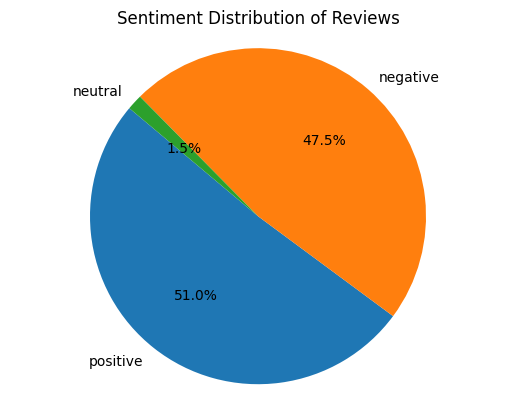

Sentiment
positive    1230
negative    1147
neutral       36
Name: count, dtype: int64

In [110]:
value_counts = reviews_data['Sentiment'].value_counts()
labels = value_counts.index
sizes = value_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Sentiment Distribution of Reviews')
plt.show()

value_counts